In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt


#For confusion matrix
import itertools

In [2]:
%%time
dir = Path('/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset')

filepaths = list(dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

CPU times: user 103 ms, sys: 120 ms, total: 224 ms
Wall time: 5.58 s


,Filepath,Label
0,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
1,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
2,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
3,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
4,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
...,...,...
6934,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid
6935,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid
6936,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid
6937,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid


In [3]:
dataframe['Label'].value_counts()

pneumonia    2313
normal       2313
covid        2313
Name: Label, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split



train , test = train_test_split(
 dataframe, test_size=0.13, random_state=0, stratify=dataframe['Label'])
train['Label'].value_counts()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


pneumonia    2012
normal       2012
covid        2012
Name: Label, dtype: int64

In [5]:
test['Label'].value_counts()

covid        301
normal       301
pneumonia    301
Name: Label, dtype: int64

In [6]:
test

,Filepath,Label
5934,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid
2481,/kaggle/input/covid19-pneumonia-normal-chest-x...,normal
621,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
1033,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
3283,/kaggle/input/covid19-pneumonia-normal-chest-x...,normal
...,...,...
1297,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
5832,/kaggle/input/covid19-pneumonia-normal-chest-x...,covid
1219,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
4565,/kaggle/input/covid19-pneumonia-normal-chest-x...,normal


In [7]:
from tensorflow.image import rgb_to_grayscale 

def pre_process(image):
    image = image = rgb_to_grayscale(image)
    return image

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_generator = ImageDataGenerator(
#     preprocessing_function=pre_process,
    rescale=1./255,
    
    validation_split=0.2
)

test_generator = ImageDataGenerator(
#     preprocessing_function=pre_process,
    rescale=1./255
)

In [9]:
SIZE=224
COLOR_MODE='rgb'
BATCH_SIZE=32


train_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(SIZE, SIZE),
    COLOR_MODE=COLOR_MODE,
    class_mode='categorical',
    BATCH_SIZE=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)


val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(SIZE, SIZE),
    COLOR_MODE=COLOR_MODE,
    class_mode='categorical',
    BATCH_SIZE=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(SIZE, SIZE),
    COLOR_MODE=COLOR_MODE,
    class_mode='categorical',
    BATCH_SIZE=BATCH_SIZE,
    shuffle=False
)

Found 4804 validated image filenames belonging to 3 classes.
Found 1201 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 31 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 31 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 897 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 6 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [10]:
test_images.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [11]:
from keras.layers import Layer, Conv2D, GlobalAveragePooling2D, Reshape, Multiply, Add, Activation
from keras import backend as K

def config_afr(input_shape, reduction_ratio=16):
    num_channels = input_shape[-1]
    num_reduced_filters = max(num_channels // reduction_ratio, 1)
    return num_channels, num_reduced_filters



class AFR(Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(AFR, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.num_channels, self.num_reduced_filters = config_afr(input_shape, self.reduction_ratio)
        self.fc1 = Conv2D(self.num_reduced_filters, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.relu1 = Activation('relu')
        self.fc2 = Conv2D(self.num_channels, kernel_size=(1, 1), strides=(1, 1), padding='same')
        self.sigmoid = Activation('sigmoid')
        super(AFR, self).build(input_shape)

    def call(self, inputs):
        x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, 1, self.num_channels))(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = Multiply()([inputs, x])
        x = Add()([inputs, x])
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(AFR, self).get_config()
        config['reduction_ratio'] = self.reduction_ratio
        return config

In [12]:
from keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model

pre_trained_model = VGG19(input_shape=(SIZE,SIZE,3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False 
    
inputs = Input(shape=(SIZE, SIZE, 3))
x1 =pre_trained_model(inputs)

x4 = AFR(reduction_ratio=8)(x1)

x=Flatten()(x4)
x=Dense(512, activation='relu')(x)
x=Dense(128, activation='relu')(x)
x=Dense(3 , activation='softmax')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 afr (AFR)                   (None, 7, 7, 512)         66112     
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                              

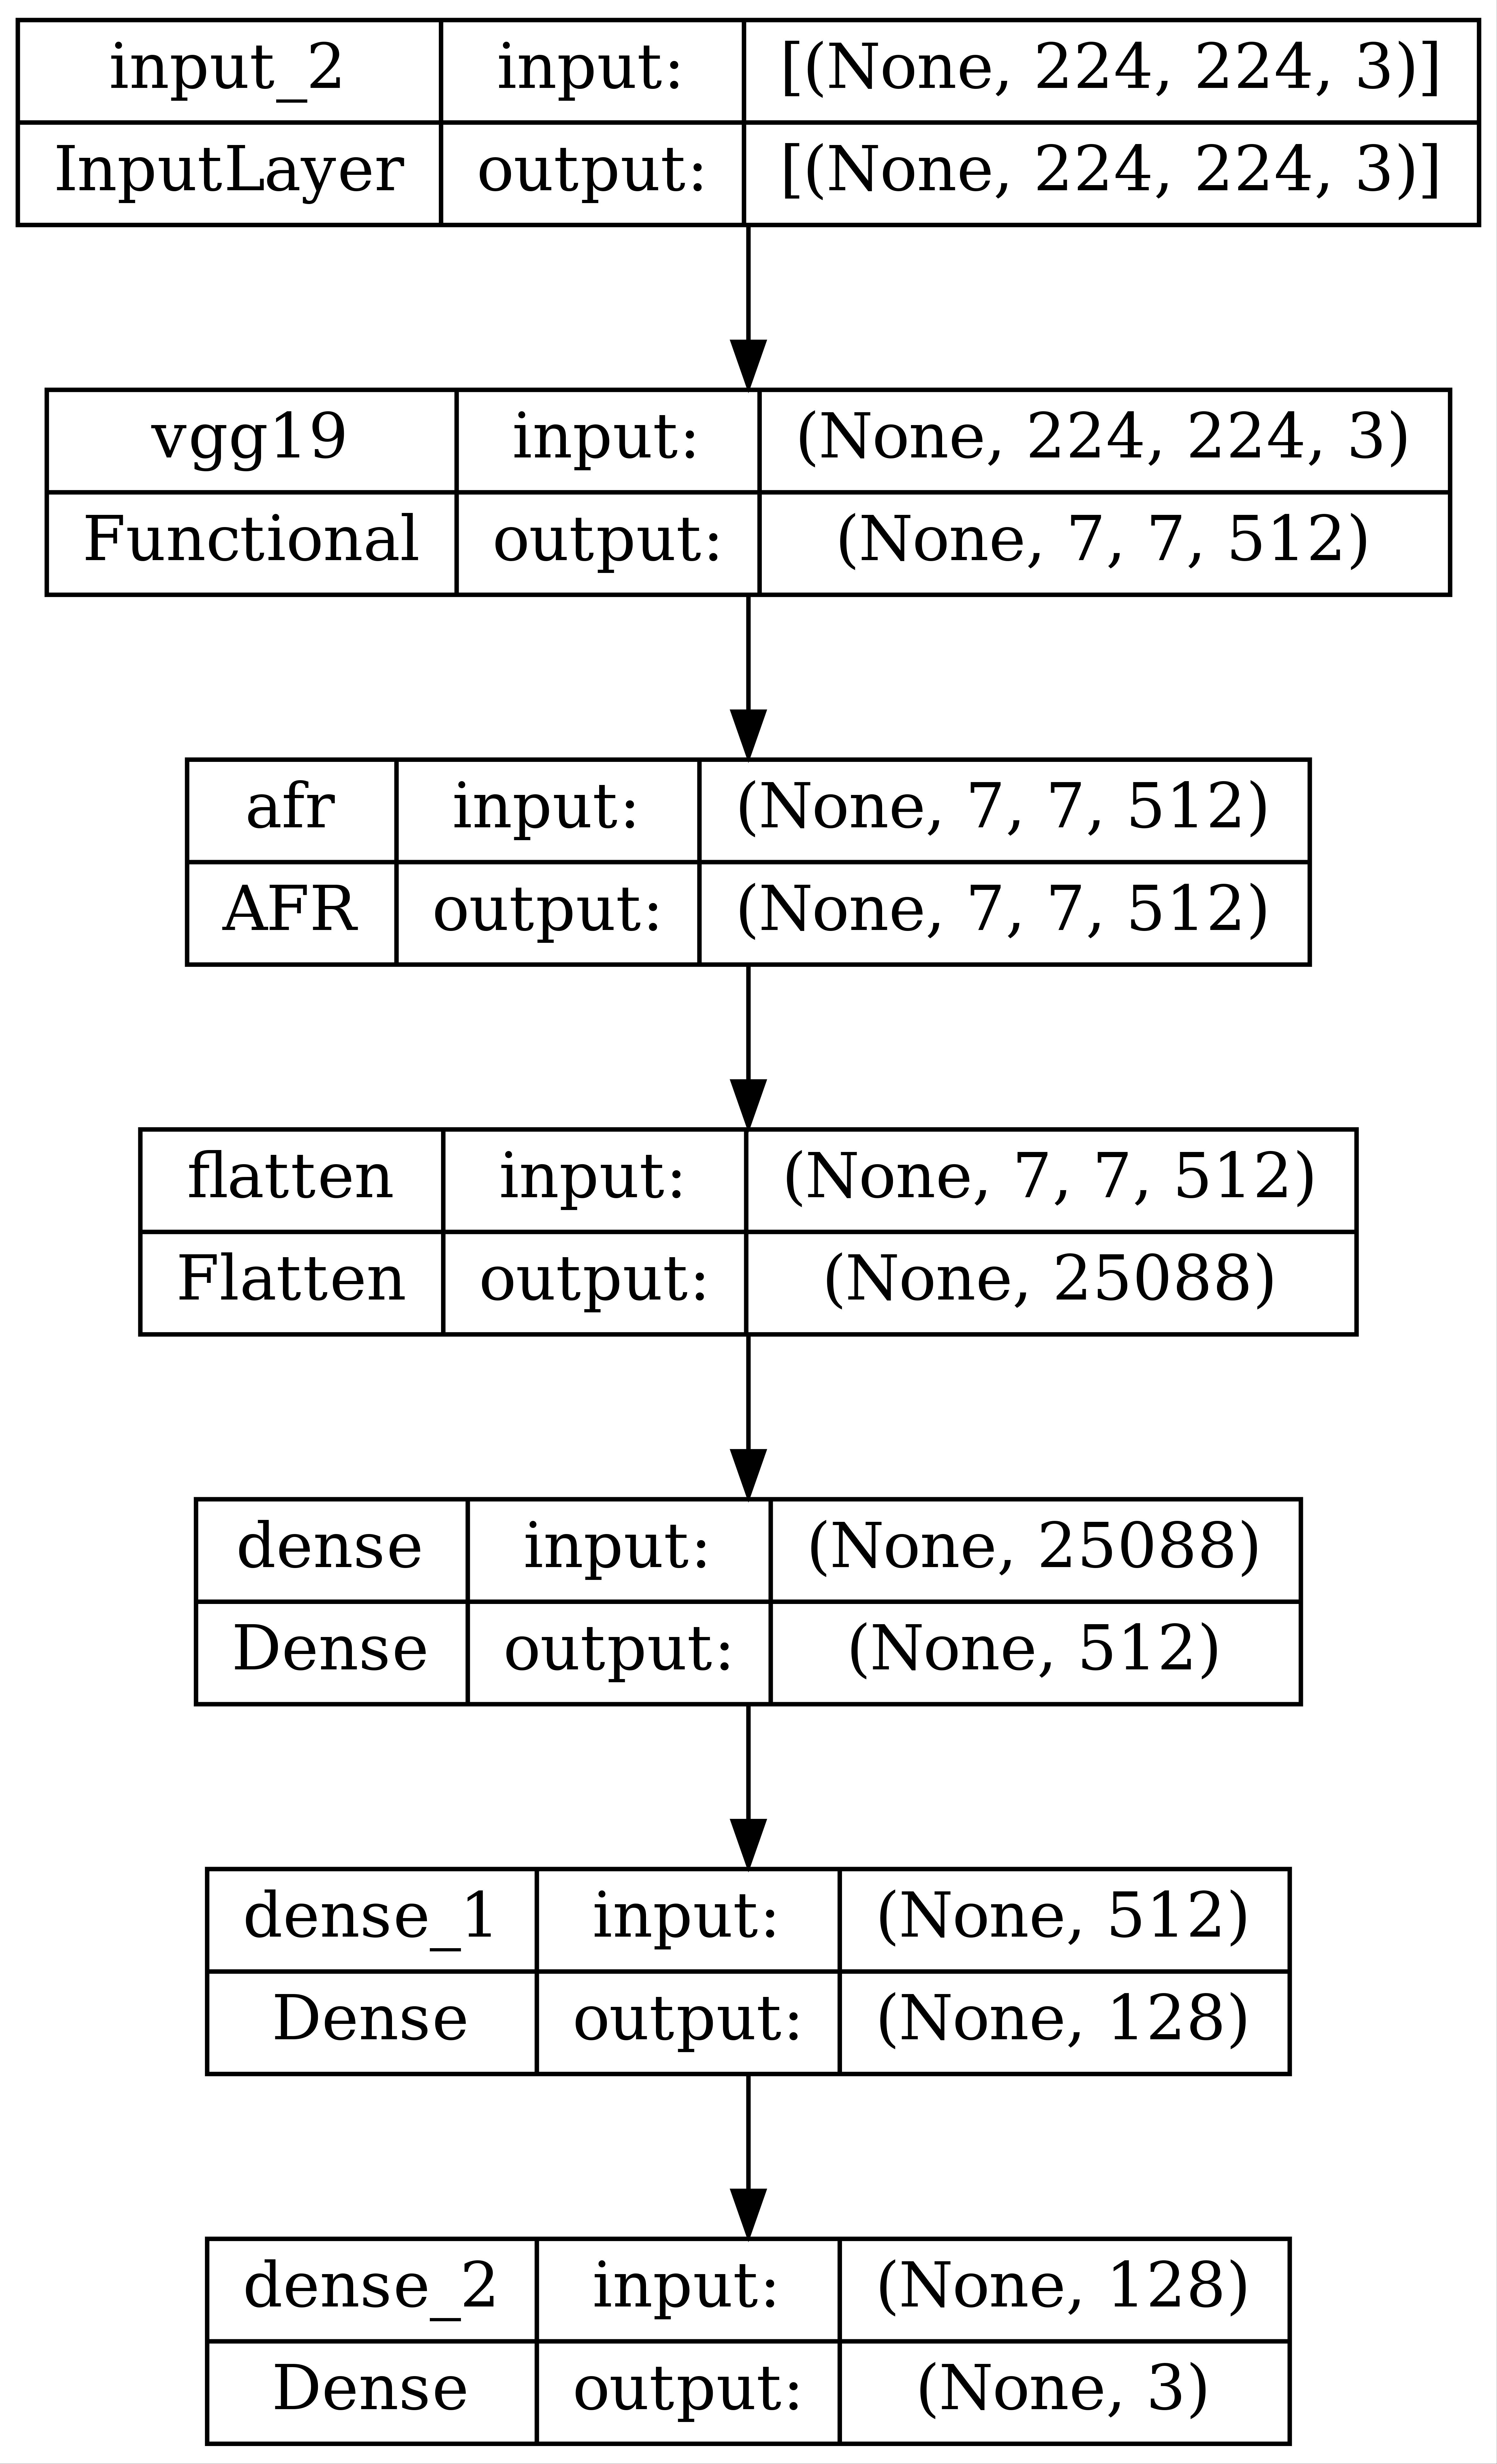

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.jpg",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=1000
)

In [14]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [15]:
from tensorflow.keras.metrics import AUC 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',
             'Precision',
             'Recall',
                    AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False,
                                    from_logits=False)
        ]
)

In [16]:
%%time
result=model.fit(
    train_images,
#     steps_per_epoch=4804//32,
    validation_data=val_images,
#     validation_steps=1201//32,
    epochs=30,
    callbacks=[checkpoint]
)

Epoch 1/30
151/151 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.8347 - precision: 0.8435 - recall: 0.8289 - auc: 0.9280
Epoch 1: val_accuracy improved from -inf to 0.80766, saving model to best_model.h5
151/151 [==============================] - 137s 805ms/step - loss: 0.8134 - accuracy: 0.8347 - precision: 0.8435 - recall: 0.8289 - auc: 0.9280 - val_loss: 0.5251 - val_accuracy: 0.8077 - val_precision: 0.8238 - val_recall: 0.8018 - val_auc: 0.9466
Epoch 2/30
151/151 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9265 - precision: 0.9307 - recall: 0.9228 - auc: 0.9846
Epoch 2: val_accuracy improved from 0.80766 to 0.93838, saving model to best_model.h5
151/151 [==============================] - 83s 548ms/step - loss: 0.2255 - accuracy: 0.9265 - precision: 0.9307 - recall: 0.9228 - auc: 0.9846 - val_loss: 0.1872 - val_accuracy: 0.9384 - val_precision: 0.9434 - val_recall: 0.9292 - val_auc: 0.9894
Epoch 3/30
151/151 [====================

In [17]:
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import cohen_kappa_score, f1_score
from keras.models import load_model

best_model=load_model('/kaggle/working/best_model.h5', custom_objects={'AFR': AFR})
results = best_model.evaluate(test_images, verbose=0)
y_pred = best_model.predict(test_images)
y_pred=np.argmax(y_pred, axis=1)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test Precision: {:.2f}%".format(results[2] * 100))
print("   Test Recall: {:.2f}%".format(results[3] * 100))
print(" Test f1-score: {:.2f}%".format(f1_score(test_images.labels, y_pred, average='micro') * 100))
print("      Test AUC: {:.4f}".format(results[4] ))
print("         Gmean: {:.2f}%".format(geometric_mean_score(test_images.labels, y_pred)*100) )
print("         kappa: {:.2f}%".format(cohen_kappa_score(test_images.labels, y_pred)*100) )

29/29 [==============================] - 12s 408ms/step
     Test Loss: 0.2922
 Test Accuracy: 95.76%
Test Precision: 95.76%
   Test Recall: 95.76%
 Test f1-score: 95.76%
      Test AUC: 0.9827
         Gmean: 95.75%
         kappa: 93.64%


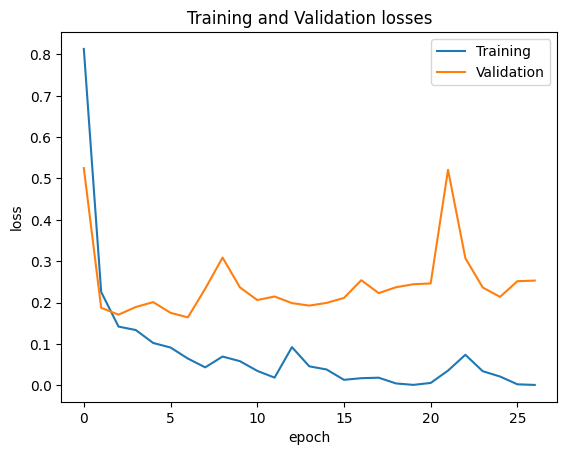

In [18]:
# print(len(result.history["loss"]))

plt.plot(result.history['loss'][:27])
plt.plot(result.history['val_loss'][:27])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

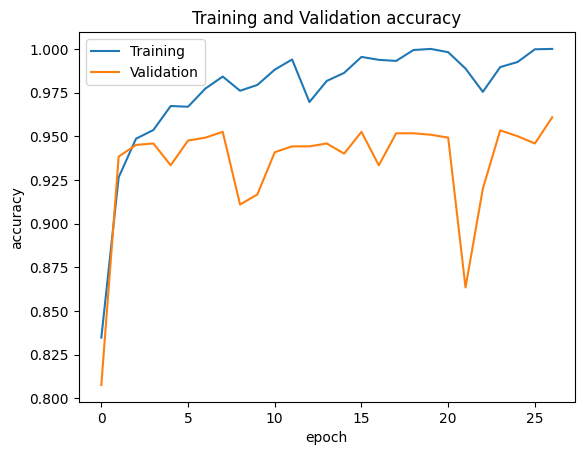

In [19]:
plt.plot(result.history['accuracy'][:27])
plt.plot(result.history['val_accuracy'][:27])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')

In [20]:
# plt.plot(result.history['auc'])
# plt.plot(result.history['val_auc'])
# plt.legend(['Training', 'Validation'])
# plt.title('Training and Validation AUC-ROC')
# plt.xlabel('epoch')
# plt.savefig( 'AUC-ROC.jpg', dpi=500, bbox_inches = 'tight')

In [21]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
cf_m = " CONFUSION MATRIX\n----------------------------------------\n"
print("\n",cf_m)
print(cm)
print("\n\nCLASSIFICATION REPORT\n----------------------------------------\n")

report = classification_report(test_images.labels, y_pred, target_names=['covid', 'normal', 'pneumonia'], digits=4)
print(report)

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)
report.to_csv('classification report.csv', index=True)


  CONFUSION MATRIX
----------------------------------------

[[285   9   1]
 [  2 293   6]
 [  0  20 281]]


CLASSIFICATION REPORT
----------------------------------------

              precision    recall  f1-score   support

       covid     0.9930    0.9661    0.9794       295
      normal     0.9099    0.9734    0.9406       301
   pneumonia     0.9757    0.9336    0.9542       301

    accuracy                         0.9576       897
   macro avg     0.9596    0.9577    0.9581       897
weighted avg     0.9593    0.9576    0.9579       897



Confusion matrix, without normalization


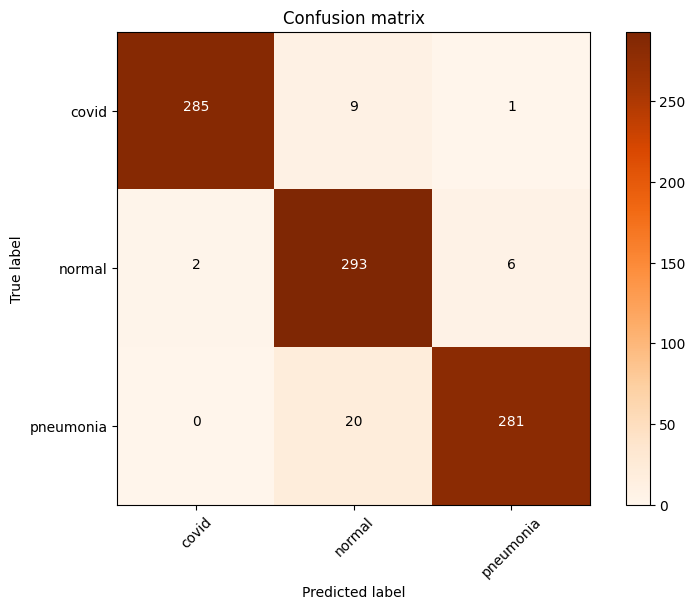

In [22]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '12'
    
    
plot_confusion_matrix(cm, classes=['covid', 'normal', 'pneumonia'],normalize=False,title='Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')

Normalized confusion matrix


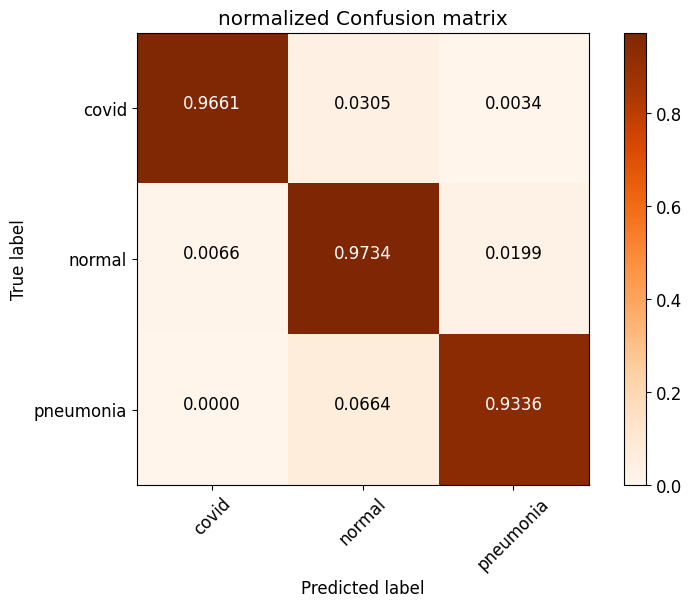

In [23]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '24'
    
    
plot_confusion_matrix(cm, classes=['covid', 'normal', 'pneumonia'],normalize=True,title='normalized Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('normalized confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')

In [24]:
# END OF CODE